# CNN 
* changed the way we classified images because they are effective in recognizing useful patterns by understanding spatial structure of the input
* require a lower quantity of parameters thx to pooling layers
* convolution with several inputs at the end

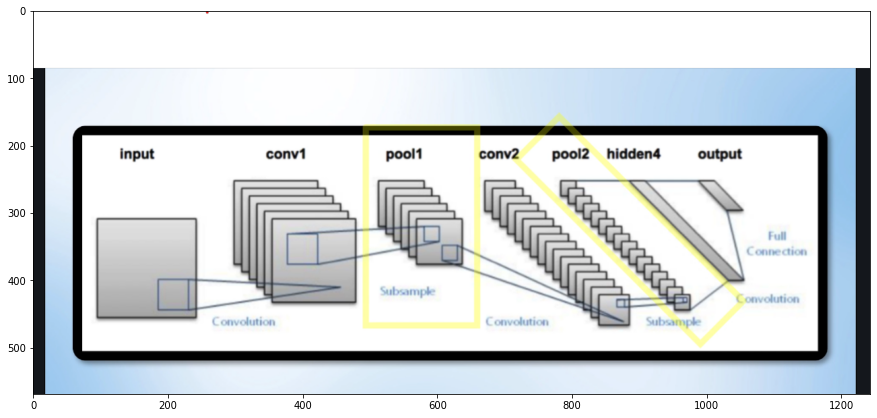

In [1]:
import PIL
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
img = Image.open("data/cnn/cnn.png")
plt.figure(figsize=(15,15))
plt.imshow(img)

# Convolutional layer
* 3 types of layers : convolutional layers, pooling layers, fully connected layers

In the convolutional layer, the primary goal is to learn and extract features. 
* the input is processed by the kernel matrix. you slide the kernel at each location on the image and the amount at which you shif it is the stride. The bigger the stride, the smaller the corresponding feature map
* the area where the operation takes place is the receptive field.  
* For each receptive field, we store a value in the feature map corresponding to the sum of the elements of the dot product of the kernel and the receptive field. 
* * NOTE : if the kernel is 3*3, the image is N*M, the stride is 1, there is no receptive field centered around first and last row and columns of pixels, the feature map has a dimension N*2 * M-2 / WE CAN ADD PADDING to avoid this phenomenon (extra border added to image)
* * NOTE 2 : in this lesson, we take the average on 9 pixels instead of the sum. It doesn't change the idea
* depending on the kernel, you detect different types of features : https://aishack.in/tutorials/image-convolution-examples/ 
* the values of the weights in the kernel are learned by the cnn during the training process. Instead of having a weight by pixel, the kernel is shared accross the image. 
* translational invariance : if a kernel detects a feature in an image, it can detect it somewhere else in the image

Text(0.5, 1.0, 'Kernel with average output')

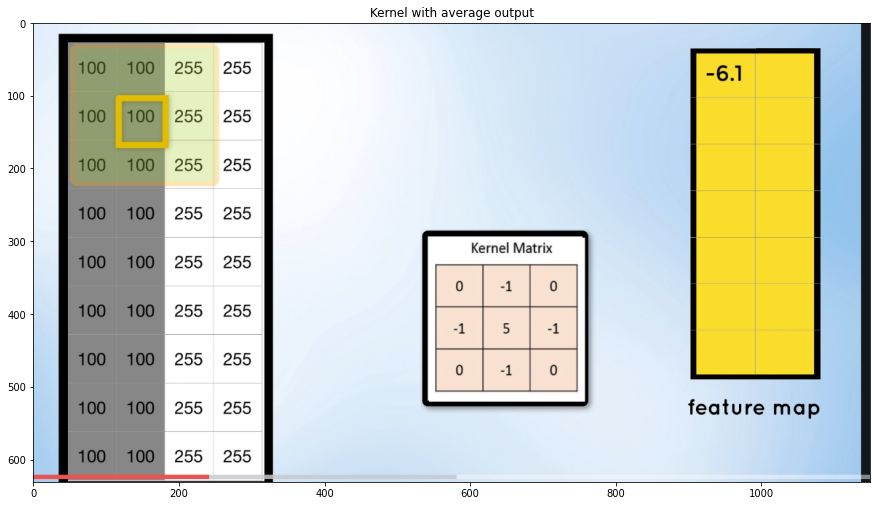

In [2]:
img = Image.open("data/cnn/receptive_field.png")
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.title("Kernel with average output")

# the depth of the kernel must match the depth of the image

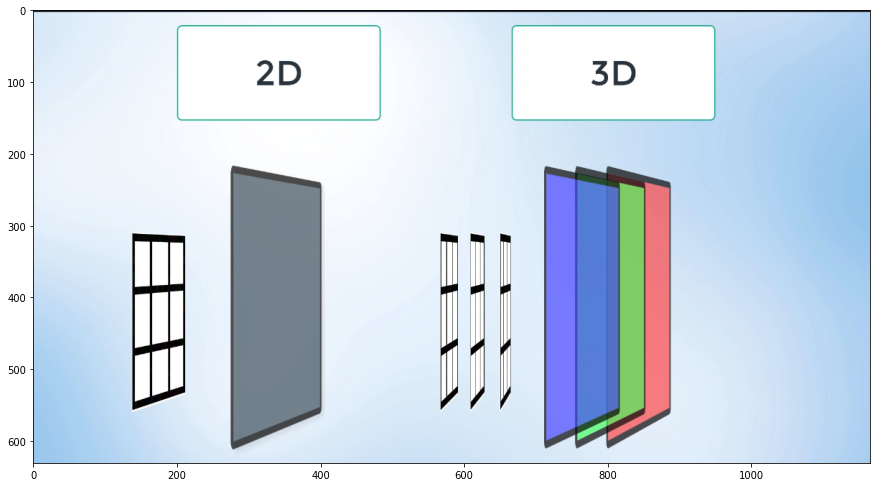

In [3]:
img = Image.open("data/cnn/kernel_depth.png")
plt.figure(figsize=(15,15))
plt.imshow(img)

### after the feature map was created, we activate it with the relu function (rectified linear unit) to create non linearity. Indeed, the convolution is a linear operation so we introduce non linearity with the relu function
* we dont use sigmoid or tanh because they are prone to vanishing gradient

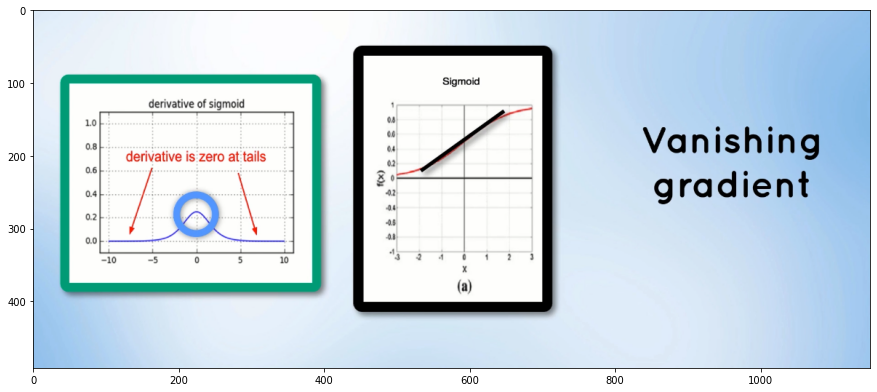

In [4]:
img = Image.open("data/cnn/vanishing_grad_sigmoid.png")
plt.figure(figsize=(15,15))
plt.imshow(img)

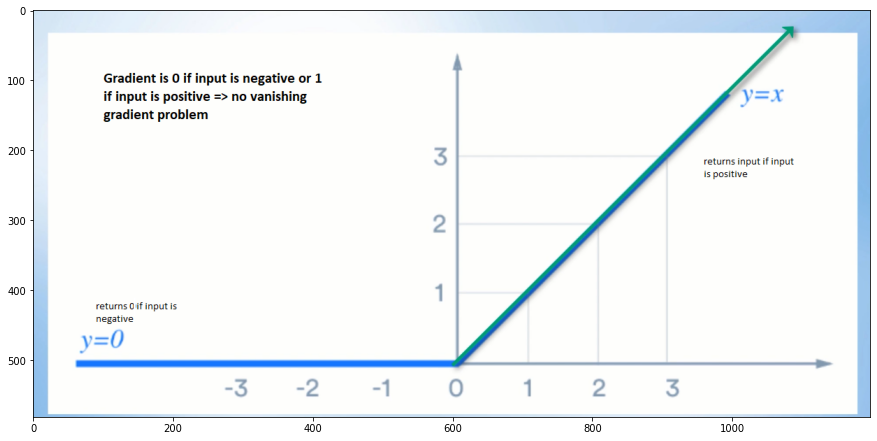

In [5]:
img = Image.open("data/cnn/relu.png")
plt.figure(figsize=(15,15))
plt.imshow(img)

Values of 1 in the feature map (before relu) correspond to part of the image that perfectly match the feature we are convolving

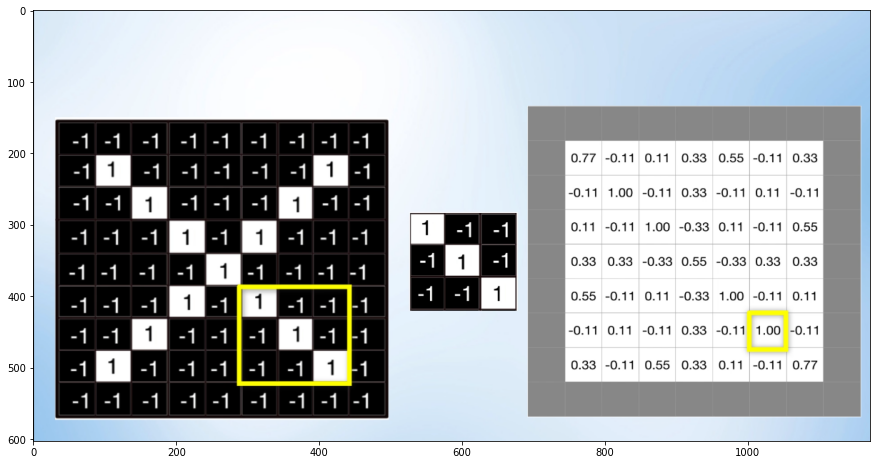

In [6]:
img = Image.open("data/cnn/xconv.png")
plt.figure(figsize=(15,15))
plt.imshow(img)

After that, for each feature map (one per kernel), we apply relu and then process the output with the pooling layer

# Pooling layer
* reduce the dimensionality of each feature map (prevent overfitting) by proviing a more generalised version of the feature map
* there are different types (sum, average, max) : max works very well as it provides a scale invariant representation of the image
* For ex, we can take a 2*2 max pooling with a stride of 2 to reduce dimensionality
* NOTE : if we take a window size too large, it can really decrease the performance
* NOTe 2 : we used several kernels for convolution but use only one operation for pooling 

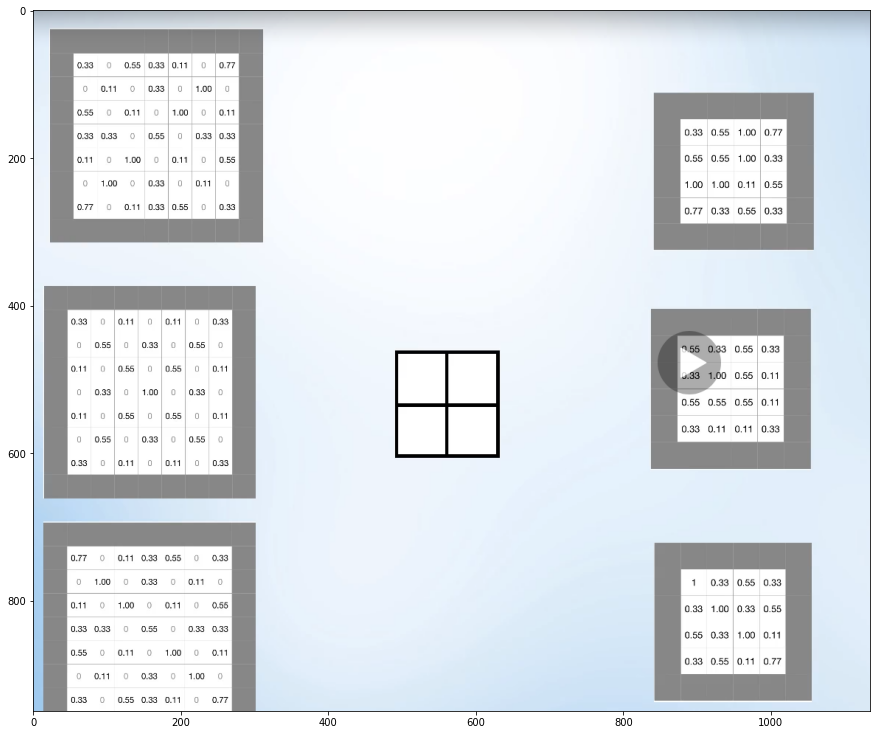

In [7]:
img = Image.open("data/cnn/maxpool.png")
plt.figure(figsize=(15,15))
plt.imshow(img)

After repeating the operation of convolution - pool several times
* first layers recognize basic shapes 
* as we go deeper, it recognizes much more sophisticated concepts

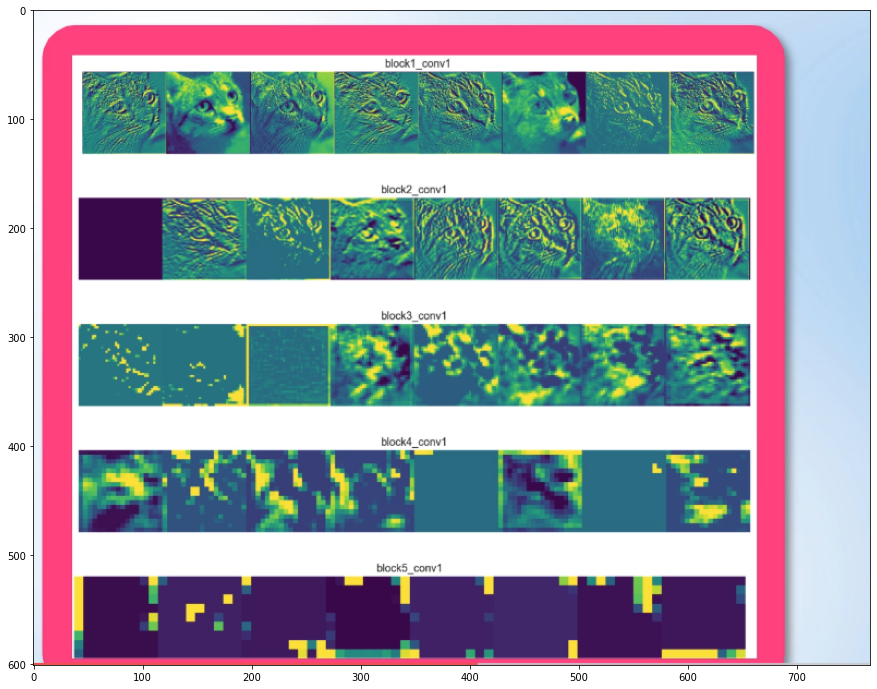

In [8]:
img = Image.open("data/cnn/catlayers.png")
plt.figure(figsize=(15,15))
plt.imshow(img)

a fun cnn at scs.ryerson.ca/~aharley/vis/conv/flat.html

# Fully connected network

* After all the convolution / pooling operations, we flatten the final feature maps (make them 1D) and feed them to a fully connected layer 
* Each node in the input layer of the FCN is a pixel
* the output can be a probability in a classification example 
* so that means, i stack convolution / pooling with standard neural network at the end
* convolution / pooling does feature extraction and FCN does classification

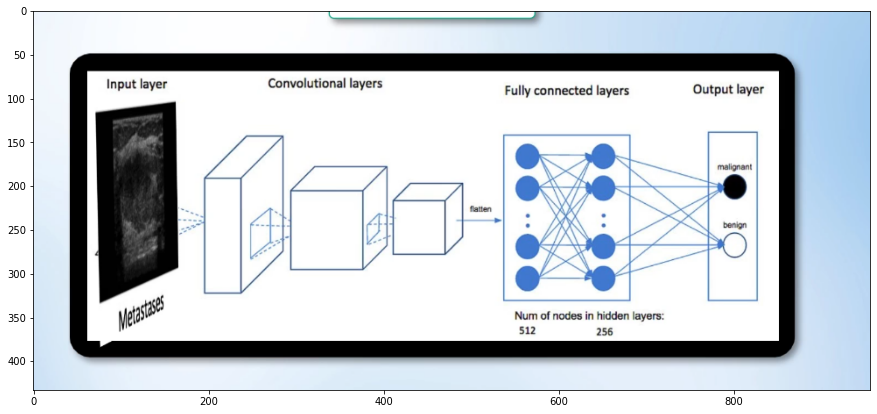

In [9]:
img = Image.open("data/cnn/cnnfcn.png")
plt.figure(figsize=(15,15))
plt.imshow(img)

In practice, how do we train it ? 
* First, the FCN is just a MLP (multilayer perceptrons)
* And in fact we use backprop on the whole network (cnn + fcn) : the difference is that the backprop is done with a convolution

# Example code

In [10]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

img = Image.open("data/paint/onethickpaint.png")
img = ImageOps.invert(img)
img = ImageOps.grayscale(img)
img = transform(img) # apply the transform defined on top

convlayer_ex = nn.Conv2d(in_channels=4, out_channels=7, kernel_size=(3,5), stride=1)

for name, param in convlayer_ex.named_parameters():
    print(name, param.shape)

weight torch.Size([7, 4, 3, 5])
bias torch.Size([7])


In [11]:
convlayer_ex.weight[1,2,:,:]

tensor([[-0.1060, -0.0830, -0.0497, -0.0793, -0.0168],
        [ 0.0279, -0.0317, -0.0787,  0.0793, -0.1009],
        [ 0.1024,  0.0245, -0.0258,  0.0276, -0.0196]],
       grad_fn=<SliceBackward>)

That means : 
* I have 4 inputs for 7 outputs
* The contribution of each input to the output is seen in weight tensor. Because my kernel is 3x5, the filter corresponding to the contribution of input 2 to output 1 is convlayer.weigth\[1,2,:,:\]
* final value of output 1 is convlayer.bias\[1\] + sum_k {convlayer.weight\[1,k,:,:\] * input(k)} where k goes from 0 to 3 and * is the convolution

General conclusion : 
* Each input is linked to each output by a different kernel. 
* The total number of parameters is nb_inputs * nb_outputs * kernel_width * kernel_height

In [12]:
easy_in = 2 
easy_out = 3
easy_image_len = 8
nb_mesures = 1
easy_conv =  nn.Conv2d(in_channels=easy_in, out_channels=easy_out, kernel_size=4, stride=1)
input1 = torch.randn(nb_mesures,easy_in, easy_image_len, easy_image_len)

input1.shape, easy_conv(input1).shape # j'ai un seul exemple, 2 channels d'entrée, 5 en sortie et la taille de l'image est légèrement réduite à cause du kernel


(torch.Size([1, 2, 8, 8]), torch.Size([1, 3, 5, 5]))

## Contrairement au modèle Linear, je ne peux pas supprimer la dimension correspondant au nombre de mesures même si je n'ai qu'une seule mesure !!!!


In [13]:
easy_conv(input1[0])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [3, 2, 4, 4], but got 3-dimensional input of size [2, 8, 8] instead

In [14]:
easy_conv.weight.shape, input1.shape, easy_conv(input1).shape, easy_conv(input1)

(torch.Size([3, 2, 4, 4]),
 torch.Size([1, 2, 8, 8]),
 torch.Size([1, 3, 5, 5]),
 tensor([[[[ 1.4978e-01, -2.0460e-01, -6.5307e-01,  1.2412e+00,  7.6146e-02],
           [-3.1424e-01,  3.2848e-01, -5.6634e-01, -4.3840e-01,  1.4746e-03],
           [-8.5841e-01,  8.4065e-01,  3.7255e-01, -3.9487e-01, -1.0262e-02],
           [ 4.0387e-01,  4.3064e-01,  1.8698e-01,  3.3906e-01,  4.4433e-01],
           [-1.2397e+00,  1.7859e-02, -1.9192e-01,  4.6507e-01, -5.1789e-01]],
 
          [[ 1.5080e-01,  3.5522e-01,  2.1978e-01,  5.1013e-01, -1.4642e+00],
           [ 5.0453e-01, -8.0217e-01, -1.0397e+00,  8.4422e-01,  6.9545e-01],
           [ 3.5817e-01,  1.7568e-01,  4.5414e-01, -1.6072e+00,  1.5107e+00],
           [-1.4572e-01,  7.6876e-02, -1.8214e-01,  9.2232e-01, -9.4427e-01],
           [ 4.3305e-01,  3.3206e-01, -9.4302e-01,  1.3362e+00, -2.3112e-01]],
 
          [[ 8.2597e-02,  9.8843e-02, -2.5569e-01,  1.5943e+00,  1.4419e-01],
           [ 4.0608e-01, -2.4808e-01, -4.0473e-01, -1.0

In [15]:
easy_conv(input1)[0,0]
input2 = input1.clone()
input3 = input1.clone()
input2[:,0,:,:] = 0
input3[:,1,:,:] = 0
(easy_conv(input2) + easy_conv(input3)) -  (easy_conv(input1) + easy_conv.bias.view(1,easy_out, 1,1)) # je soustrais le biais car il est compté deux fois à gauche vu que je passe deux fois dans la convolution

tensor([[[[-5.9605e-08,  4.4703e-08, -5.9605e-08,  0.0000e+00,  0.0000e+00],
          [ 8.9407e-08,  2.9802e-08,  5.9605e-08, -2.9802e-08,  3.9814e-08],
          [ 0.0000e+00, -5.9605e-08,  0.0000e+00,  8.9407e-08, -4.5635e-08],
          [ 0.0000e+00, -2.9802e-08,  1.4901e-08,  5.9605e-08, -8.9407e-08],
          [ 1.1921e-07,  2.7940e-08,  0.0000e+00,  2.9802e-08,  0.0000e+00]],

         [[ 2.9802e-08,  2.9802e-08,  2.9802e-08, -5.9605e-08, -1.1921e-07],
          [-5.9605e-08,  0.0000e+00,  5.9605e-08, -1.7881e-07,  0.0000e+00],
          [-8.9407e-08,  8.9407e-08,  0.0000e+00, -1.1921e-07,  1.1921e-07],
          [ 8.9407e-08, -4.4703e-08, -2.9802e-08,  0.0000e+00,  0.0000e+00],
          [ 1.1921e-07,  1.1921e-07,  0.0000e+00,  1.1921e-07, -7.4506e-08]],

         [[ 2.9802e-08,  0.0000e+00,  1.4901e-08,  0.0000e+00, -8.9407e-08],
          [-5.9605e-08,  0.0000e+00, -5.9605e-08,  0.0000e+00,  0.0000e+00],
          [-2.9802e-08,  0.0000e+00,  0.0000e+00,  5.9605e-08, -4.4703e-

In [16]:
nn.functional.conv2d(input1, easy_conv.weight) -( nn.functional.conv2d(input2, easy_conv.weight) + nn.functional.conv2d(input3, easy_conv.weight))

tensor([[[[ 5.9605e-08, -2.9802e-08,  5.9605e-08,  0.0000e+00,  4.4703e-08],
          [-8.9407e-08,  0.0000e+00, -5.9605e-08,  2.9802e-08, -2.4913e-08],
          [ 5.9605e-08,  0.0000e+00,  0.0000e+00, -2.9802e-08,  3.8184e-08],
          [ 2.9802e-08,  5.9605e-08, -1.4901e-08, -2.9802e-08,  5.9605e-08],
          [-1.1921e-07, -5.7742e-08,  2.9802e-08, -5.9605e-08,  0.0000e+00]],

         [[ 2.6077e-08,  2.9802e-08,  1.4901e-08,  2.9802e-08,  1.1921e-07],
          [-2.9802e-08,  5.9605e-08,  0.0000e+00,  1.1921e-07,  0.0000e+00],
          [ 5.9605e-08, -1.1176e-08,  0.0000e+00,  1.1921e-07, -2.3842e-07],
          [-2.9802e-08, -3.7253e-08,  0.0000e+00, -5.9605e-08, -1.1921e-07],
          [ 0.0000e+00, -1.4901e-08,  0.0000e+00,  0.0000e+00,  2.9802e-08]],

         [[ 3.9116e-08,  6.5193e-09,  0.0000e+00,  0.0000e+00,  4.4703e-08],
          [ 2.9802e-08,  2.9802e-08, -5.9605e-08,  0.0000e+00,  0.0000e+00],
          [ 2.9802e-08, -5.9605e-08, -2.2352e-08, -1.7881e-07, -8.9407e-

## DONC, aux erreurs de calcul près, c'est pareil. Ca veut dire que, pour chaque channel d'entrée, un kernel différent contribue à l'output et la sortie est égale à la somme de ces sorties intermédiaires

Formula: Number of Parameters in a Convolutional Layer

The number of parameters in a convolutional layer depends on the supplied values of filters/out_channels, kernel_size, and input_shape. Let's define a few variables:

    K - the number of filters in the convolutional layer
    F - the height and width of the convolutional filters
    D_in - the depth of the previous layer

Notice that K = out_channels, and F = kernel_size. Likewise, D_in is the last value in the input_shape tuple, typically 1 or 3 (RGB and grayscale, respectively).

Since there are F*F*D_in weights per filter, and the convolutional layer is composed of K filters, the total number of weights in the convolutional layer is KxFxFxD_in. Since there is one bias term per filter, the convolutional layer has K biases. Thus, the number of parameters in the convolutional layer is given by  __KxFxFxD_in + K__ .
Formula: Shape of a Convolutional Layer

The shape of a convolutional layer depends on the supplied values of kernel_size, input_shape, padding, and stride. Let's define a few variables:

    K - the number of filters in the convolutional layer
    F - the height and width of the convolutional filters
    S - the stride of the convolution
    P - the padding
    W_in - the width/height (square) of the previous layer

Notice that K = out_channels, F = kernel_size, and S = stride. Likewise, W_in is the first and second value of the input_shape tuple.

The depth of the convolutional layer will always equal the number of filters K.

The spatial dimensions of a convolutional layer can be calculated as: __(W_in−F+2P)/S+1__